In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np 
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import rcParams
from scipy import interpolate
import pandas as pd

## Define functions

In [2]:
# single transient Ca2+ function
# use a hill equation and its flipped form to simulate the Ca transient
def CaFunc(t,params):
    initial=params['initial']      # define how long the initial steady-state is
    setpoint=params['setpoint']    # define how long the transient lasts
    n=params['n']                  # n and Kd define the shape of the transient
    Kd=params['Kd']
  
    if t<initial:
        return 0.0
    elif t<(initial+setpoint):
        return (t-initial)**n/(Kd+(t-initial)**n)
    else:
        return Kd/(Kd+(t-initial-setpoint)**n)
    

In [3]:
# pacing function
# essentially multiple single transient Ca2+ function concatenated
def pacingFunc(params,debug=False):
    
    tBasal=params['tBasal']  # initial basal Ca2+ duration 
    tTrans=params['tTrans']  # Ca2+ oscillation duration 
    tEnd=params['tEnd']      # ending basal Ca2+ duration
    freq=params['freq']      # pacing frequency (Hz)
    noise=params['noise']    # whether to add artificial noise or not

    timeStep=10 # number of time step per second for simulation (10 steps/sec)
    tTotal=0    # total time duration (basically a counter and will increase as we go along the time axis)
    timeStepTotal=0 # total time step (basically a counter and will increase as we go along the time axis)
    noiseVal=0 # 0 when noise==False; some random value when noise==True
    Ca=[]      # a list to store Ca2+ oscillation values at each time point
    
    # only one pacing frequency
    if type(freq) != list:              
        if freq == 0.0:
            tTotal=tBasal+tTrans+tEnd
            timeStepTotal=int(tTotal*timeStep)
            
            totalTime=np.linspace(0,tTotal,timeStepTotal)
            for t in totalTime:
                if noise:
                    noiseVal=np.random.normal(0.02,0.01)
                Ca.append(CaFunc(0,params)+noiseVal)
                        
        else:
            # initial basal Ca period       
            basalTime=np.linspace(0,tBasal,int(tBasal*timeStep))
            tTotal+=tBasal
            timeStepTotal+=int(tBasal*timeStep)
            for t in basalTime:
                if noise:
                    noiseVal=np.random.normal(0.02,0.01)
                Ca.append(CaFunc(0,params)+noiseVal)   

            # transients
            tTotal+=tTrans
            tPulse=round(1/freq,1)
            iters=int(tTrans/tPulse) # number of pulses

            pulseTime=np.linspace(0,tPulse,int(tPulse*timeStep))
            for i in range(iters):
                timeStepTotal+=int(tPulse*timeStep)
                for t in pulseTime:
                    if noise:
                        noiseVal=np.random.normal(0.02,0.01)
                    Ca.append(CaFunc(t,params)+noiseVal)
                    
            # ending basal Ca period
            endTime=np.linspace(0,tBasal,int(tEnd*timeStep))
            tTotal+=tEnd
            timeStepTotal+=int(tEnd*timeStep)
            for t in endTime:
                if noise:
                    noiseVal=np.random.normal(0.02,0.01)
                Ca.append(CaFunc(0,params)+noiseVal)
        
    # when there is more than one freq
    else:                
        # initial basal Ca period
        basalTime=np.linspace(0,tBasal,int(tBasal*timeStep))
        tTotal+=tBasal
        timeStepTotal+=int(tBasal*timeStep)
        for t in basalTime:
            if noise:
                noiseVal=np.random.normal(0.02,0.01)
            Ca.append(CaFunc(0,params)+noiseVal)
                
        # transients
        for f in freq:  
            tPulse=round(1/f,1)
            iters=int(tTrans/tPulse)
            pulseTime=np.linspace(0,tPulse,int(tPulse*timeStep))
            tTotal+=tTrans
                       
            for i in range(iters):       
                timeStepTotal+=int(tPulse*timeStep)
                for t in pulseTime:
                    if noise:
                        noiseVal=np.random.normal(0.02,0.01)
                    Ca.append(CaFunc(t,params)+noiseVal)
        
        # ending basal Ca period
        endTime=np.linspace(0,tBasal,int(tEnd*timeStep))
        tTotal+=tEnd
        timeStepTotal+=int(tEnd*timeStep)
        for t in endTime:
            if noise:
                noiseVal=np.random.normal(0.02,0.01)
            Ca.append(CaFunc(0,params)+noiseVal)

    Ca=np.array(Ca)

    return Ca,tTotal,timeStepTotal

In [4]:
# interpolate the pacing Ca function so that Ca2+ oscillation will synchronize with the time steps for simulation
def interpolation(params):
    
    tEnd=params['tEnd']
    Ca,tTotal,timeSteps=pacingFunc(params)
    ts=np.linspace(0,tTotal,timeSteps)

    # conversion
    if np.max(Ca)!=0:
      Ca-=np.min(Ca)
      Ca+=params['Cadia']/(params['Casys']-params['Cadia'])  
      Ca/=np.max(Ca)
      Ca*=params['Casys']   
    else:
      Ca+=params['Cadia']
    
    f=interpolate.interp1d(ts,Ca,fill_value="extrapolate")
    
    return f,tTotal,timeSteps

In [5]:
# define model (described by a set of ordinary differential equations)
def dydt(t,y,params,cafunc,singleTransient=False):
    
    DB,SB,P,DW,SW = y
    
    #if singleTransient:
    #    Ca = cafunc(t,params)
    #else:
    Ca = cafunc(t)
    
    Bt = params['Bt']
    Et = params['Et']
    Wt = params['Wt']
    k2f= params['k2f']
    k2b= params['k2b']
    k3f= params['k3f']
    k3b=params['k3b']
    k4f= params['k4f']
    k4b= params['k4b']
    k5f= params['k5f']
    k5b= params['k5b']
    k6f= params['k6f']
    k6b= params['k6b']
    
    S = Ca*Et - (SB+SW)
    B = Bt-(DB+SB+P)
    D = Et-(S+SB+DB+SW+DW)
    W = Wt-(DW+SW)
    
    dDBdt = k2f*B*D - k2b*DB
    dSBdt = k3f*B*S - k3b*SB
    dPdt = k4f*B - k4b*P
    dDWdt = k5f*W*D - k5b*DW
    dSWdt = k6f*W*S - k6b*SW
    
    return(
        [dDBdt,
        dSBdt,
        dPdt,
        dDWdt,
        dSWdt])

In [6]:
# run simulation
def simulation(params,singleTransient=False,plot=False,output_file=None,plotStates=None,normalize=False):
    output={} # create a dictionary to save the outputs

    if singleTransient:
        duration=params['tTrans']
        t0s=np.linspace(0,100,1000)
        ts=np.linspace(0,duration,1000)
        Cas=np.array([CaFunc(t,params) for t in ts])
        #cafunc=CaFunc
        
        # conversion
        if np.max(Cas)!=0:
          Cas-=np.min(Cas)
          Cas+=params['Cadia']/(params['Casys']-params['Cadia'])  
          Cas/=np.max(Cas)
          Cas*=params['Casys']      
        else:
          Cas+=params['Cadia']
        cafunc=interpolate.interp1d(ts,Cas,fill_value="extrapolate")
        
    else:
        cafunc,duration,timeSteps=interpolation(params)
        ts=np.linspace(0,duration,timeSteps)
        t0s=ts
        Cas=cafunc(ts)
   
    y0s=params['y0s']
    simulation=solve_ivp(dydt,[0,duration],y0s,args=(params,cafunc,singleTransient,),t_eval=ts)
    ys=simulation.y
    y0s=ys[:,-1]
    simulation=solve_ivp(dydt,[0,duration],y0s,args=(params,cafunc,singleTransient,),t_eval=ts)
    ys=simulation.y
        
    output['ts']=ts
    output['Ca']=Cas
    output['DB'],output['SB'],output['P'],output['DW'],output['SW']=ys[0],ys[1],ys[2],ys[3],ys[4]
    output['B']=params['Bt']-(output['DB']+output['SB']+output['P'])
    output['S']=output['Ca']*params['Et'] - (output['SB']+output['SW'])
    output['D']=params['Et'] - (output['S']+output['SB']+output['DB']+output['DW']+output['SW'])
    output['W']=params['Wt']-(output['DW']+output['SW'])
    output['SERCA-PLB']=output['DB']+output['SB']
    output['SERCA-DWF']=output['DW']+output['SW']
    output['free SERCA']=output['D']+output['S']
    output['Dt']=output['D']+output['DB']+output['DW']
    output['St']=output['S']+output['SB']+output['SW']
    
    
    if plot:
        rcParams['figure.figsize']=4,4
        rcParams['font.size']=15
        fig=plt.figure()
        
        for state in plotStates:
            if normalize:
                dat=output[state]
                dat-=np.min(dat)
                dat/=np.max(dat)
            plt.plot(ts,output[state],label=state)
        plt.legend(bbox_to_anchor=(1,1))
    
    if output_file is not None:
        df=pd.DataFrame.from_dict(output)
        df.to_csv(output_file)
        
    return output


In [7]:
# to compare the outcome of different values of the same parameter
def compare(var,varVals,params,plotStates=None,singleTransient=True,plotInSame=True,output_file_header=None,normalize=False):
    if plotInSame:
        fig=plt.figure()
    styles=['-','--','-.',':']
    cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
    
    for i,val in enumerate(varVals):
        params[var]=val
        sim=simulation(params,singleTransient=singleTransient,plot=False,output_file='{}_{}_{}.csv'.format(output_file_header,var,val))
        
        if plotInSame:
            for j,state in enumerate(plotStates):
                dat=sim[state]
                if normalize:
                    dat-=np.min(dat)
                    dat/=np.max(dat)
                plt.plot(sim['ts'],dat,linestyle=styles[0],label='{}_{}'.format(state,val),color=cols[i])
                plt.legend(bbox_to_anchor=(1,1))
    
        

In [8]:
# values obatined from fitting to experimental data
truth={
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

# initial values for the simulatio
DPLB_0 = 0.5
SPLB_0 = 0
PLBp_0 = 0.5
DW_0=0.5
SW_0=0


## Simulations

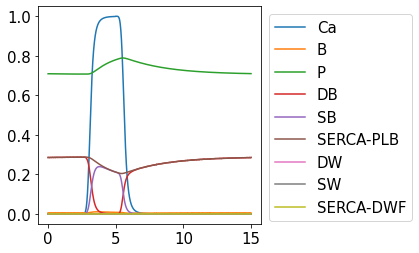

In [ ]:
# single transient (PLB alone)
# parameters used
params={
    'initial':2.5,
    'setpoint':2.5,  
    'n': 5,
    'Kd': 0.1,
    'tTrans': 15,
    'Cadia': 0.0, 
    'Casys': 1.0,
    'y0s':[DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':1.0, 
    'Et':1.0,  
    'Wt':0.0,
}

# states to plot
plotStates=['Ca','B','P','DB','SB','SERCA-PLB','DW','SW','SERCA-DWF']

# uncomment the output_file argument to write output file in csv (can rename the file as desired)
sim=simulation(params,singleTransient=True,plot=True,plotStates=plotStates)#,output_file='singleTransient.csv')

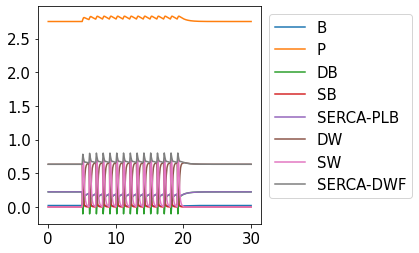

In [ ]:
# pacing
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 5,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'noise': False,      # option to add in noise
    'Cadia':0.0,
    'Casys':1.0,
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

plotStates=['B','P','DB','SB','SERCA-PLB','DW','SW','SERCA-DWF']

# uncomment the output_file argument to write output file in csv (can rename the file as desired)
sim=simulation(pacingParams,singleTransient=False,plot=True,plotStates=plotStates)#,output_file='pacing_1Hz.csv') 

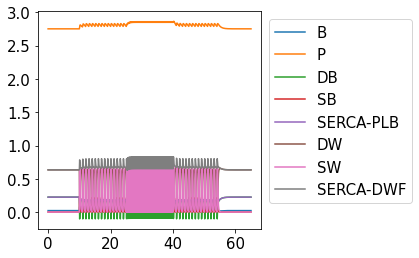

In [ ]:
# switch pacing frequencies
switchPacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 10,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':[1.0, 3.0, 1.0],          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'Cadia':0.0,
    'Casys':1.0,
    'noise': False,      # option to add in noise
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0, 
}

plotStates=['B','P','DB','SB','SERCA-PLB','DW','SW','SERCA-DWF']

# uncomment the output_file argument to write output file in csv (can rename the file as desired)
sim=simulation(switchPacingParams,singleTransient=False,plot=True,plotStates=plotStates)#,output_file='pacing_1-3-1Hz.csv')


## Different pacing frequencies with no DWF

In [9]:
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 5,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'Cadia':0.0,
    'Casys':1.0,
    'noise': False,      # option to add in noise
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':0.0,
}

freq:  0.0 Hz
SERCA-PLB occupancy:  0.5796866148348412
PLB pentamer occupancy:  2.4013906815643997
SERCA-PLB oscillation amplitude:  0.0020240432165178346
PLB pentamer oscillation amplitude:  5.2453545849040495e-06
freq:  1.0 Hz
SERCA-PLB occupancy:  0.5164384091120247
PLB pentamer occupancy:  2.464026905622302
SERCA-PLB oscillation amplitude:  0.030701964767295586
PLB pentamer oscillation amplitude:  0.02289320297859021
freq:  1.5 Hz


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


SERCA-PLB occupancy:  0.4985039192939452
PLB pentamer occupancy:  2.482508059442009
SERCA-PLB oscillation amplitude:  0.025271541593777258
PLB pentamer oscillation amplitude:  0.01608771867171388
freq:  2.0 Hz


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


SERCA-PLB occupancy:  0.4819953633729161
PLB pentamer occupancy:  2.499529062074882
SERCA-PLB oscillation amplitude:  0.019682691590840906
PLB pentamer oscillation amplitude:  0.009423420796340398
freq:  3.0 Hz


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


SERCA-PLB occupancy:  0.4692823162818831
PLB pentamer occupancy:  2.512417309480961
SERCA-PLB oscillation amplitude:  0.014239731760561647
PLB pentamer oscillation amplitude:  0.0045362584694848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


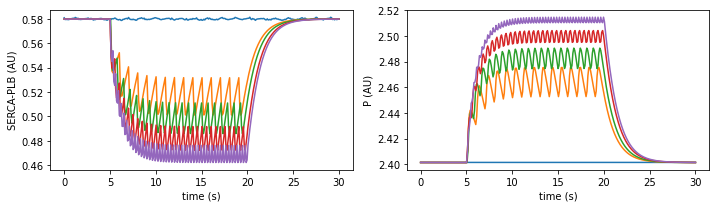

In [10]:
# different pacing freq with no DWF
ps=pacingParams.copy()
ps['Wt']=0.0
toPlot=['SERCA-PLB', 'P']
freqs=[0.0, 1.0, 1.5, 2.0, 3.0]

rcParams['figure.figsize']=15,3
fig=plt.figure()
for freq in freqs: 
    print('freq: ', freq, 'Hz')
    ps['freq']=freq
    sim=simulation(ps,output_file='noDWF_pacing_{}Hz.csv'.format(freq)) 
    ts=sim['ts']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(sim['SERCA-PLB'][120:160])+np.min(sim['SERCA-PLB'][120:160]))/2
    P_eq=(np.max(sim['P'][120:160])+np.min(sim['P'][120:160]))/2
    EB_amp=np.max(sim['SERCA-PLB'][120:160])-np.min(sim['SERCA-PLB'][120:160]) 
    P_amp=np.max(sim['P'][120:160])-np.min(sim['P'][120:160])  
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    print('PLB pentamer oscillation amplitude: ', P_amp)
    
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.plot(ts,sim[label])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('{} (AU)'.format(label))
        
plt.tight_layout()

## Different Wt at different pacing frequencies

Wt:  0.0
SERCA-PLB occupancy:  0.5796866148348412
PLB pentamer occupancy:  2.4013906815643997
SERCA-PLB oscillation amplitude:  0.0020240432165178346
Wt:  0.3
SERCA-PLB occupancy:  0.5146290152827955
PLB pentamer occupancy:  2.466002992644537
SERCA-PLB oscillation amplitude:  0.002346837854494299
Wt:  1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.37053328930218776
PLB pentamer occupancy:  2.608895633424495
SERCA-PLB oscillation amplitude:  0.001211861783226631
Wt:  1.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.3360662758976552
PLB pentamer occupancy:  2.643051573293266
SERCA-PLB oscillation amplitude:  0.0013057337218701504
Wt:  2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.2895183661021586
PLB pentamer occupancy:  2.6893011322563956
SERCA-PLB oscillation amplitude:  0.000950763068170879
Wt:  3.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.22430456851467373
PLB pentamer occupancy:  2.7540000469076187
SERCA-PLB oscillation amplitude:  0.0008606824667087287
Wt:  6.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.13099760567734126
PLB pentamer occupancy:  2.84655311286412
SERCA-PLB oscillation amplitude:  0.0004984339398105553


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

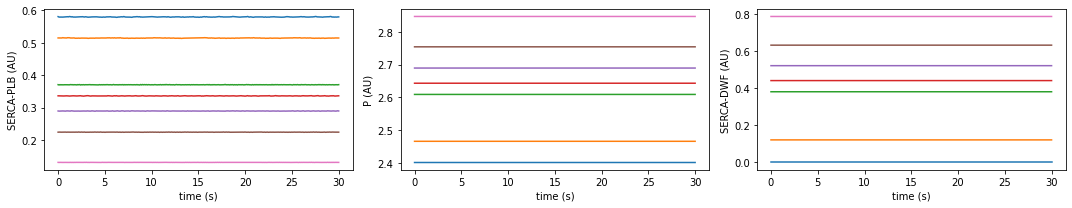

In [11]:
# different Wt at 0 Hz
ps=pacingParams.copy()
ps['freq']=0.0
toPlot=['SERCA-PLB', 'P', 'SERCA-DWF']
Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
fig=plt.figure()

for Wt in Wts: 
    print('Wt: ', Wt)
    ps['Wt']=Wt
    sim=simulation(ps,output_file='pacing_0Hz_Wt_{}.csv'.format(Wt)) 
    ts=sim['ts']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(sim['SERCA-PLB'][120:160])+np.min(sim['SERCA-PLB'][120:160]))/2
    P_eq=(np.max(sim['P'][120:160])+np.min(sim['P'][120:160]))/2
    EB_amp=np.max(sim['SERCA-PLB'][120:160])-np.min(sim['SERCA-PLB'][120:160])   
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.plot(ts,sim[label])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('{} (AU)'.format(label))
        
plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.5164384091120247
PLB pentamer occupancy:  2.464026905622302
SERCA-PLB oscillation amplitude:  0.030701964767295586
Wt:  0.3
SERCA-PLB occupancy:  0.4487429347061006
PLB pentamer occupancy:  2.5307188366425697
SERCA-PLB oscillation amplitude:  0.03568832659878213
Wt:  1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.29899574876741825
PLB pentamer occupancy:  2.677301130396704
SERCA-PLB oscillation amplitude:  0.049789644485335516
Wt:  1.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.26325984338583897
PLB pentamer occupancy:  2.710775237231564
SERCA-PLB oscillation amplitude:  0.055783985136857034
Wt:  2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.21626260490878674
PLB pentamer occupancy:  2.754369631878037
SERCA-PLB oscillation amplitude:  0.06395011776011272
Wt:  3.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.15398779099374496
PLB pentamer occupancy:  2.811592247706576
SERCA-PLB oscillation amplitude:  0.0745857364900665
Wt:  6.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.07376144354241149
PLB pentamer occupancy:  2.885687856893198
SERCA-PLB oscillation amplitude:  0.08278135886089938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

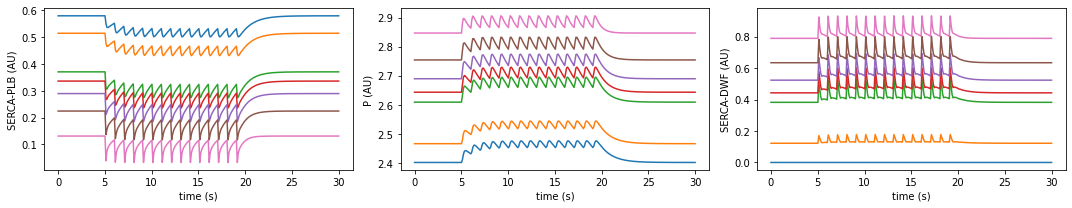

In [ ]:
# different Wt at 1 Hz
ps=pacingParams.copy()
ps['freq']=1.0
toPlot=['SERCA-PLB', 'P', 'SERCA-DWF']
Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
fig=plt.figure()

for Wt in Wts: 
    print('Wt: ', Wt)
    ps['Wt']=Wt
    sim=simulation(ps,output_file='pacing_1Hz_Wt_{}.csv'.format(Wt)) 
    ts=sim['ts']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(sim['SERCA-PLB'][120:160])+np.min(sim['SERCA-PLB'][120:160]))/2
    P_eq=(np.max(sim['P'][120:160])+np.min(sim['P'][120:160]))/2
    EB_amp=np.max(sim['SERCA-PLB'][120:160])-np.min(sim['SERCA-PLB'][120:160])   
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.plot(ts,sim[label])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('{} (AU)'.format(label))
        
plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.4985039192939452
PLB pentamer occupancy:  2.482508059442009
SERCA-PLB oscillation amplitude:  0.025271541593777258
Wt:  0.3
SERCA-PLB occupancy:  0.4311639326957196
PLB pentamer occupancy:  2.549039521026187
SERCA-PLB oscillation amplitude:  0.029364341973037222
Wt:  1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.28088124957527727
PLB pentamer occupancy:  2.6949866978851533
SERCA-PLB oscillation amplitude:  0.0442605488278775
Wt:  1.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.24572243148370126
PLB pentamer occupancy:  2.7280677957763233
SERCA-PLB oscillation amplitude:  0.049843680820131825
Wt:  2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.1999785139811801
PLB pentamer occupancy:  2.771178164886045
SERCA-PLB oscillation amplitude:  0.05749673745848405
Wt:  3.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.14053164605586685
PLB pentamer occupancy:  2.8265123744606226
SERCA-PLB oscillation amplitude:  0.06759251041704163
Wt:  6.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.06658799080644702
PLB pentamer occupancy:  2.89468526254002
SERCA-PLB oscillation amplitude:  0.07594494853273526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

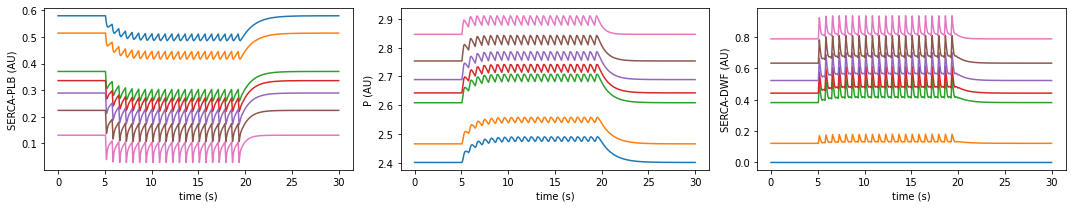

In [12]:
# different Wt at 1.5 Hz
ps=pacingParams.copy()
ps['freq']=1.5
toPlot=['SERCA-PLB', 'P', 'SERCA-DWF']
Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
fig=plt.figure()

for Wt in Wts: 
    print('Wt: ', Wt)
    ps['Wt']=Wt
    sim=simulation(ps,output_file='pacing_1p5Hz_Wt_{}.csv'.format(Wt)) 
    ts=sim['ts']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(sim['SERCA-PLB'][120:160])+np.min(sim['SERCA-PLB'][120:160]))/2
    P_eq=(np.max(sim['P'][120:160])+np.min(sim['P'][120:160]))/2
    EB_amp=np.max(sim['SERCA-PLB'][120:160])-np.min(sim['SERCA-PLB'][120:160])   
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.plot(ts,sim[label])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('{} (AU)'.format(label))
        
plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.4819953633729161
PLB pentamer occupancy:  2.499529062074882
SERCA-PLB oscillation amplitude:  0.019682691590840906
Wt:  0.3
SERCA-PLB occupancy:  0.415043772592853
PLB pentamer occupancy:  2.565876447520906
SERCA-PLB oscillation amplitude:  0.022892642885101067
Wt:  1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.2634732163556922
PLB pentamer occupancy:  2.712773099902342
SERCA-PLB oscillation amplitude:  0.039529215609415996
Wt:  1.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.2287036571863727
PLB pentamer occupancy:  2.745847248630549
SERCA-PLB oscillation amplitude:  0.0447737143673842
Wt:  2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.18392050061392923
PLB pentamer occupancy:  2.7880767224566116
SERCA-PLB oscillation amplitude:  0.052020318245299374
Wt:  3.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.12687495640011848
PLB pentamer occupancy:  2.841184063090208
SERCA-PLB oscillation amplitude:  0.06166910147226731
Wt:  6.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.058654002089947345
PLB pentamer occupancy:  2.9040935169863475
SERCA-PLB oscillation amplitude:  0.07006918206795924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

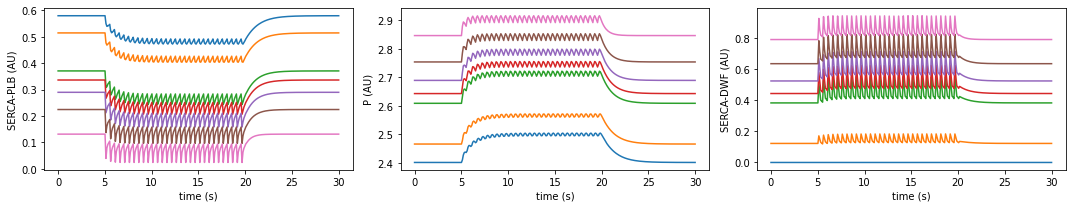

In [ ]:
# different Wt at 2 Hz
ps=pacingParams.copy()
ps['freq']=2.0
toPlot=['SERCA-PLB', 'P', 'SERCA-DWF']
Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
fig=plt.figure()

for Wt in Wts: 
    print('Wt: ', Wt)
    ps['Wt']=Wt
    sim=simulation(ps,output_file='pacing_2Hz_Wt_{}.csv'.format(Wt))
    ts=sim['ts']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(sim['SERCA-PLB'][120:160])+np.min(sim['SERCA-PLB'][120:160]))/2
    P_eq=(np.max(sim['P'][120:160])+np.min(sim['P'][120:160]))/2
    EB_amp=np.max(sim['SERCA-PLB'][120:160])-np.min(sim['SERCA-PLB'][120:160])   
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.plot(ts,sim[label])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('{} (AU)'.format(label))
        
plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.4692823162818831
PLB pentamer occupancy:  2.512417309480961
SERCA-PLB oscillation amplitude:  0.014239731760561647
Wt:  0.3
SERCA-PLB occupancy:  0.4010084342839579
PLB pentamer occupancy:  2.58012320568493
SERCA-PLB oscillation amplitude:  0.019140052473323843
Wt:  1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.24683873772844633
PLB pentamer occupancy:  2.7296028004653703
SERCA-PLB oscillation amplitude:  0.03528930741725478
Wt:  1.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.21179272705066265
PLB pentamer occupancy:  2.7630197622167305
SERCA-PLB oscillation amplitude:  0.03998610596632371
Wt:  2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.1671548638763205
PLB pentamer occupancy:  2.8052333326488514
SERCA-PLB oscillation amplitude:  0.046481739388941457
Wt:  3.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.11180815171377038
PLB pentamer occupancy:  2.8570113606575678
SERCA-PLB oscillation amplitude:  0.055073176546156816
Wt:  6.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

SERCA-PLB occupancy:  0.04957409628173757
PLB pentamer occupancy:  2.9155133895964296
SERCA-PLB oscillation amplitude:  0.06264342320373324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

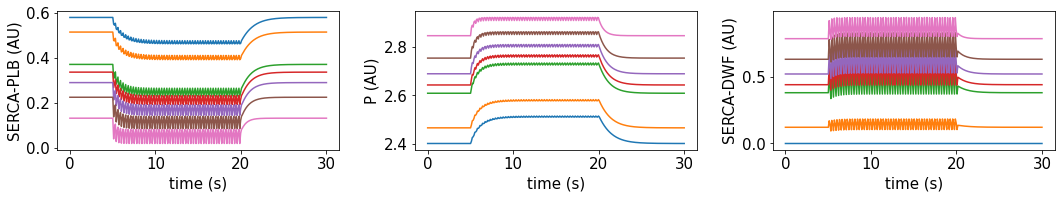

In [ ]:
# different Wt at 3 Hz
ps=pacingParams.copy()
ps['freq']=3.0
toPlot=['SERCA-PLB', 'P', 'SERCA-DWF']
Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
fig=plt.figure()

for Wt in Wts: 
    print('Wt: ', Wt)
    ps['Wt']=Wt
    sim=simulation(ps,output_file='pacing_3Hz_Wt_{}.csv'.format(Wt)) 
    ts=sim['ts']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(sim['SERCA-PLB'][120:160])+np.min(sim['SERCA-PLB'][120:160]))/2
    P_eq=(np.max(sim['P'][120:160])+np.min(sim['P'][120:160]))/2
    EB_amp=np.max(sim['SERCA-PLB'][120:160])-np.min(sim['SERCA-PLB'][120:160])   
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.plot(ts,sim[label])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('{} (AU)'.format(label))
        
plt.tight_layout()

## Healthy vs heart failure (HF)
- 40% less SERCA
- Cadia=0.1
- Try different Wt

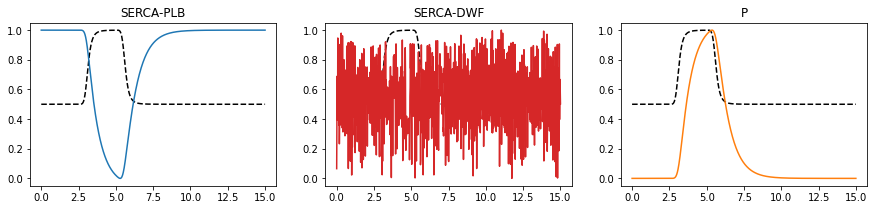

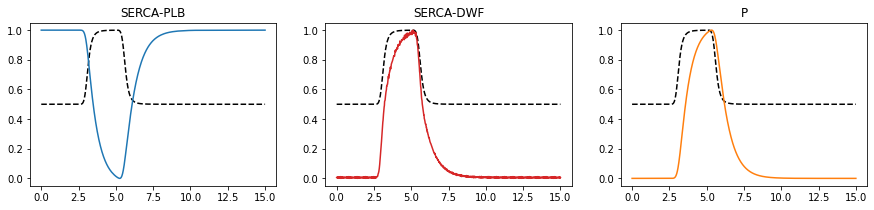

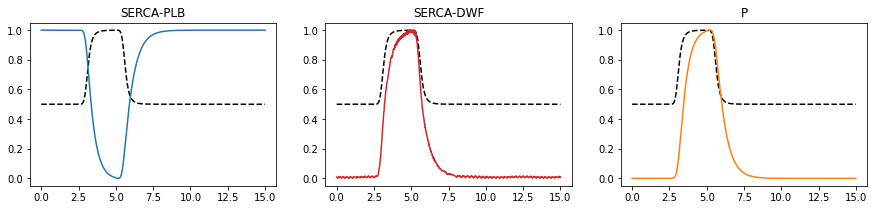

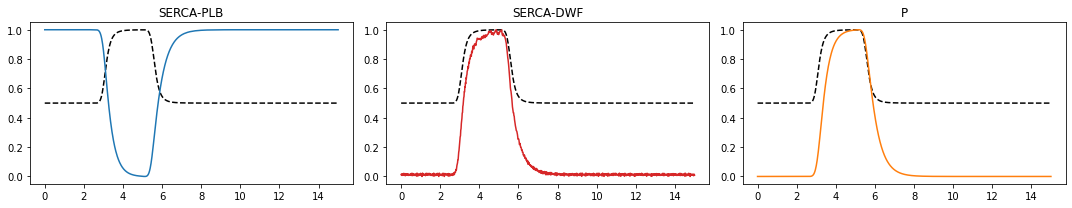

In [16]:
# single transient
# params
# parameters used
params={
    'initial':2.5,
    'setpoint':2.5,  
    'n': 5,
    'Kd': 0.1,
    'tTrans': 15,
    'Cadia': 0.0, # 0
    'Casys': 1.0,
    'y0s':[DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

Wts=[0.0, 0.3, 1.5, 3.0]

rcParams['figure.figsize']=15,3
# states to plot
toPlot=['SERCA-PLB','SERCA-DWF','P']
cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
normalize=True

for Wt in Wts:
    fig=plt.figure()
    hfParams=params.copy()
    hfParams['Wt']=Wt
    hfParams['Et']=truth['Et']*0.6
    hfParams['Cadia']=0.5
    hf=simulation(hfParams,singleTransient=True)#,output_file='singleTransient.csv')
    ts=hf['ts']
    Cas=hf['Ca']

    # plot & compare
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(label)
        ax.plot(ts,Cas,'k--')
        vals=hf[label]

        if normalize:
            vals-=np.min(vals)
            vals/=np.max(vals)

        ax.plot(ts,vals,color=cols[i],label='{}_{}'.format(label,key))

        #plt.legend(loc=1,fontsize=10)

plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.30117575606896896
PLB pentamer occupancy:  2.67767064038878
SERCA-PLB oscillation amplitude:  8.706419746262739e-08
Wt:  0.3
SERCA-PLB occupancy:  0.25221064478847893
PLB pentamer occupancy:  2.726252327227439
SERCA-PLB oscillation amplitude:  4.263759572187276e-06
Wt:  1.2
SERCA-PLB occupancy:  0.1619449921778681
PLB pentamer occupancy:  2.815809352755914
SERCA-PLB oscillation amplitude:  5.5853386883852885e-06
Wt:  1.5
SERCA-PLB occupancy:  0.1436400663790887
PLB pentamer occupancy:  2.8339712058189495
SERCA-PLB oscillation amplitude:  5.076053663344293e-06
Wt:  2.0
SERCA-PLB occupancy:  0.12045302324408466
PLB pentamer occupancy:  2.856976415714348
SERCA-PLB oscillation amplitude:  4.356313533904199e-06
Wt:  3.0
SERCA-PLB occupancy:  0.09054496522197558
PLB pentamer occupancy:  2.8866501511037352
SERCA-PLB oscillation amplitude:  2.787904309034528e-06
Wt:  6.0
SERCA-PLB occupancy:  0.051403222766990705
PLB pentamer occupancy:  2.9254852961150295
SERC

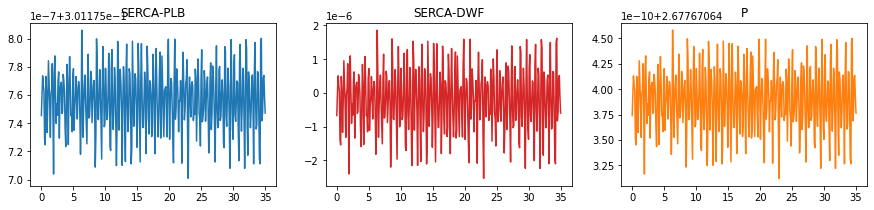

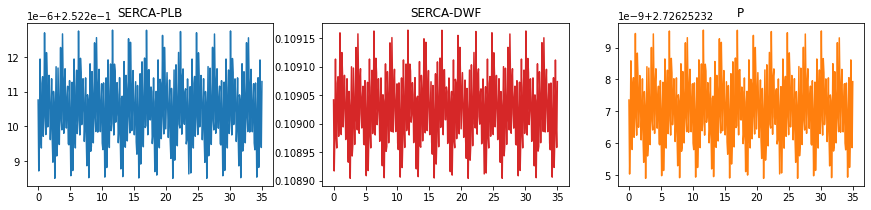

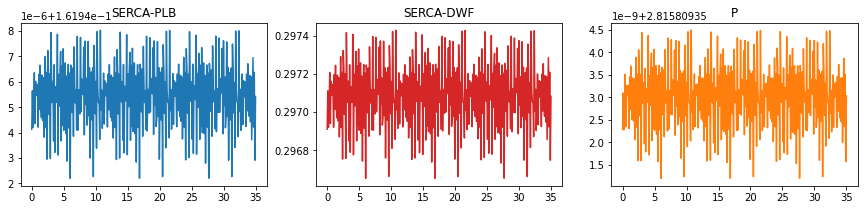

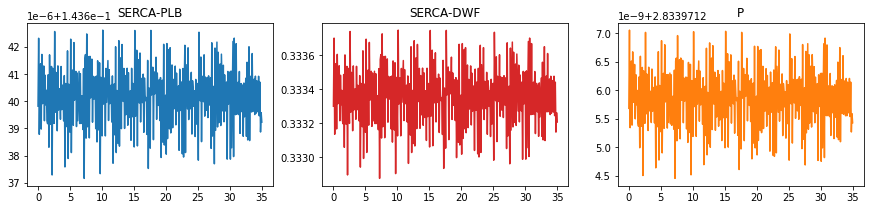

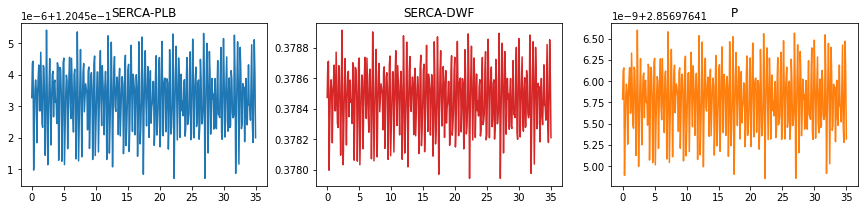

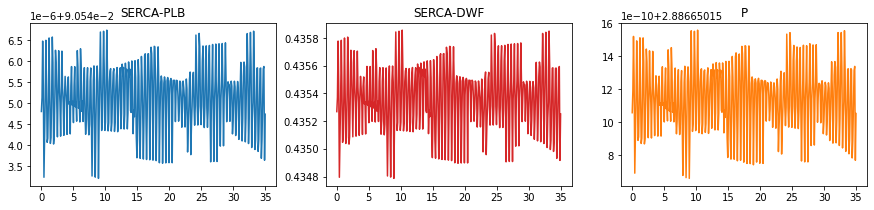

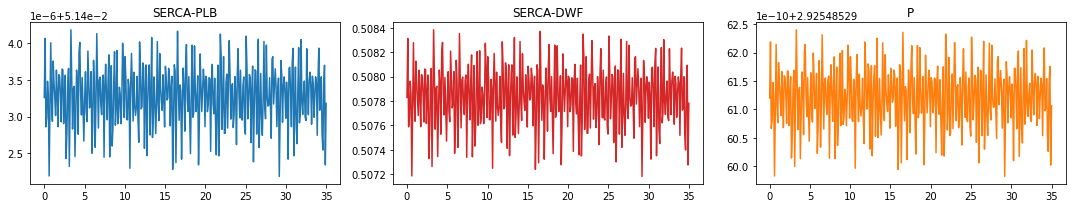

In [ ]:
# 0 Hz pacing
# params
# parameters used
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 10,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'noise': False,      # option to add in noise
    'Cadia':0.0,
    'Casys':1.0,
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

pacingParams['freq']=0.0

Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
# states to plot
toPlot=['SERCA-PLB','SERCA-DWF','P']
cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
normalize=False

for Wt in Wts:
    fig=plt.figure()
    hfParams=pacingParams.copy()
    hfParams['Wt']=Wt
    hfParams['Et']=truth['Et']*0.6
    hfParams['Cadia']=0.5
    hf=simulation(hfParams,output_file='hf_0Hz_{}_Wt.csv'.format(Wt))
    ts=hf['ts']
    Cas=hf['Ca']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(hf['SERCA-PLB'][150:200])+np.min(hf['SERCA-PLB'][150:200]))/2
    P_eq=(np.max(hf['P'][150:200])+np.min(hf['P'][150:200]))/2
    EB_amp=np.max(hf['SERCA-PLB'][150:200])-np.min(hf['SERCA-PLB'][150:200])
    print('Wt: ', Wt)
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    # plot & compare
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(label)
        #ax.plot(ts,Cas,'k--')
        vals=hf[label]

        if normalize:
            vals-=np.min(vals)
            vals/=np.max(vals)

        ax.plot(ts,vals,color=cols[i],label='{}_{}'.format(label,key))

        #plt.legend(loc=1,fontsize=10)

plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.2830449323665064
PLB pentamer occupancy:  2.6955488915287753
SERCA-PLB oscillation amplitude:  0.014748232554173846
Wt:  0.3
SERCA-PLB occupancy:  0.23274095985210821
PLB pentamer occupancy:  2.745212299798159
SERCA-PLB oscillation amplitude:  0.017930333508714924
Wt:  1.2
SERCA-PLB occupancy:  0.14140776942174493
PLB pentamer occupancy:  2.835030520970369
SERCA-PLB oscillation amplitude:  0.024071475243612694
Wt:  1.5
SERCA-PLB occupancy:  0.12296465582146715
PLB pentamer occupancy:  2.8525238766618095
SERCA-PLB oscillation amplitude:  0.026104330273237594
Wt:  2.0
SERCA-PLB occupancy:  0.10000532693774826
PLB pentamer occupancy:  2.8741538680906853
SERCA-PLB oscillation amplitude:  0.028404099177498393
Wt:  3.0
SERCA-PLB occupancy:  0.07127455399127128
PLB pentamer occupancy:  2.901168177779229
SERCA-PLB oscillation amplitude:  0.030304910641853172
Wt:  6.0
SERCA-PLB occupancy:  0.036120787345508235
PLB pentamer occupancy:  2.93525997469912
SERCA-PLB 

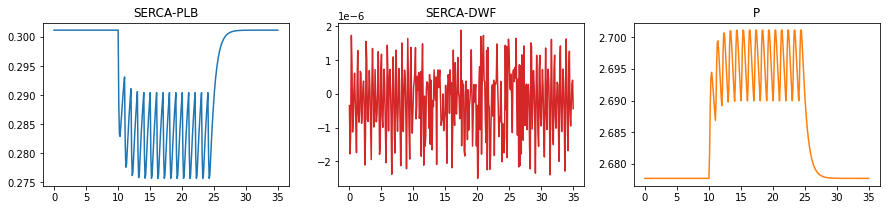

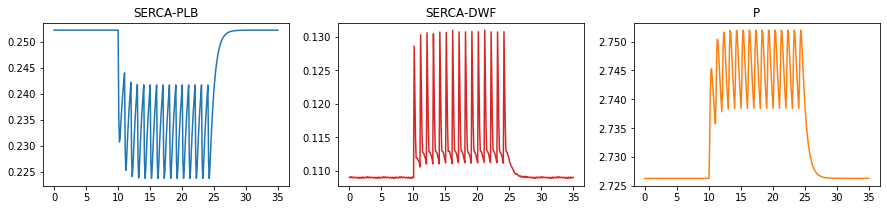

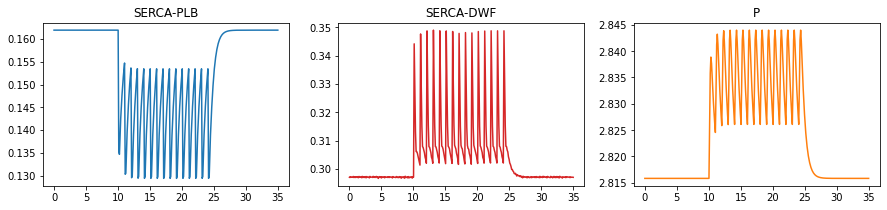

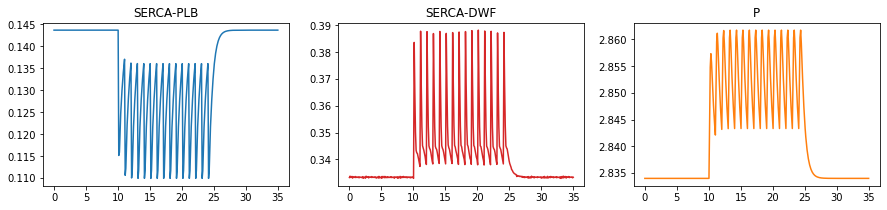

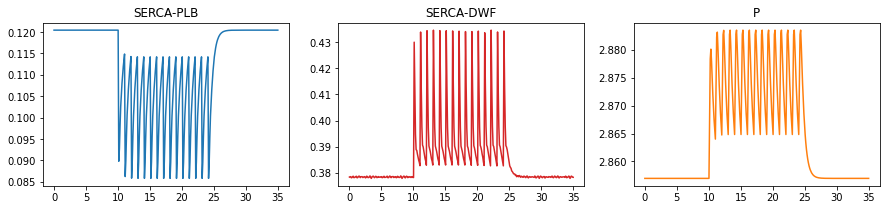

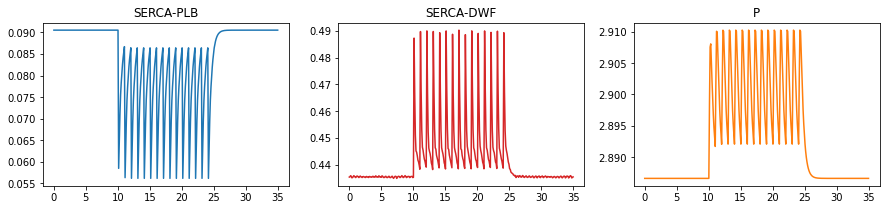

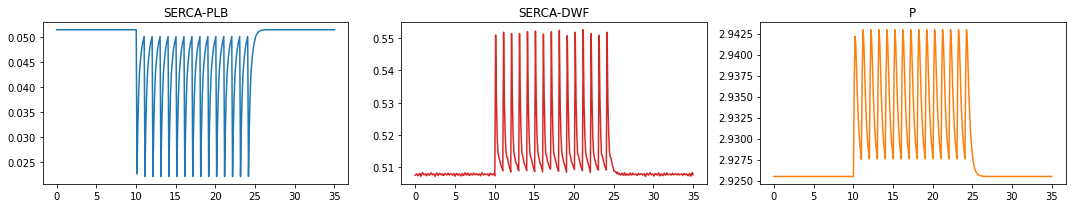

In [17]:
# 1 Hz pacing
# params
# parameters used
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 10,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'noise': False,      # option to add in noise
    'Cadia':0.0,
    'Casys':1.0,
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

pacingParams['freq']=1.0

Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
# states to plot
toPlot=['SERCA-PLB','SERCA-DWF','P']
cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
normalize=False

for Wt in Wts:
    fig=plt.figure()
    hfParams=pacingParams.copy()
    hfParams['Wt']=Wt
    hfParams['Et']=truth['Et']*0.6
    hfParams['Cadia']=0.5
    hf=simulation(hfParams,output_file='hf_1Hz_{}_Wt.csv'.format(Wt))
    ts=hf['ts']
    Cas=hf['Ca']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(hf['SERCA-PLB'][150:200])+np.min(hf['SERCA-PLB'][150:200]))/2
    P_eq=(np.max(hf['P'][150:200])+np.min(hf['P'][150:200]))/2
    EB_amp=np.max(hf['SERCA-PLB'][150:200])-np.min(hf['SERCA-PLB'][150:200])
    print('Wt: ', Wt)
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    # plot & compare
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(label)
        #ax.plot(ts,Cas,'k--')       
        vals=hf[label]

        if normalize:
            vals-=np.min(vals)
            vals/=np.max(vals)

        ax.plot(ts,vals,color=cols[i],label='{}_{}'.format(label,key))

        #plt.legend(loc=1,fontsize=10)

plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.27761704726661846
PLB pentamer occupancy:  2.701388171012729
SERCA-PLB oscillation amplitude:  0.012573769883771235
Wt:  0.3
SERCA-PLB occupancy:  0.22737929837929893
PLB pentamer occupancy:  2.7510824469614654
SERCA-PLB oscillation amplitude:  0.015386244777463753
Wt:  1.2
SERCA-PLB occupancy:  0.13620171281683952
PLB pentamer occupancy:  2.8402299794024826
SERCA-PLB oscillation amplitude:  0.02231379167858072
Wt:  1.5
SERCA-PLB occupancy:  0.11815168909021392
PLB pentamer occupancy:  2.857356228940203
SERCA-PLB oscillation amplitude:  0.024309188180453856
Wt:  2.0
SERCA-PLB occupancy:  0.09586505267219786
PLB pentamer occupancy:  2.8786480726418295
SERCA-PLB oscillation amplitude:  0.026590182272836257
Wt:  3.0
SERCA-PLB occupancy:  0.0682869305562438
PLB pentamer occupancy:  2.904910295922208
SERCA-PLB oscillation amplitude:  0.02858503530709882
Wt:  6.0
SERCA-PLB occupancy:  0.034939030588080545
PLB pentamer occupancy:  2.937081945716324
SERCA-PLB o

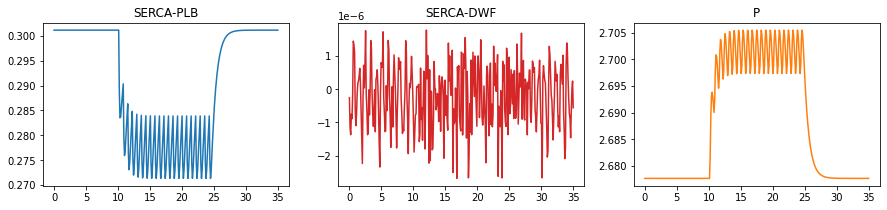

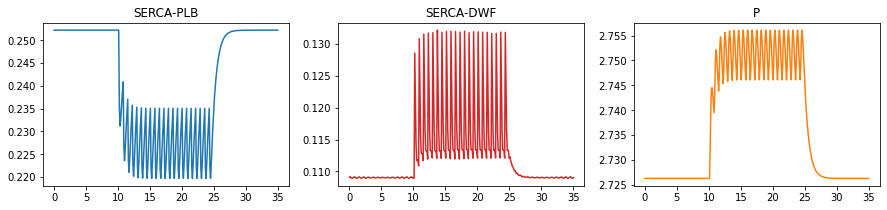

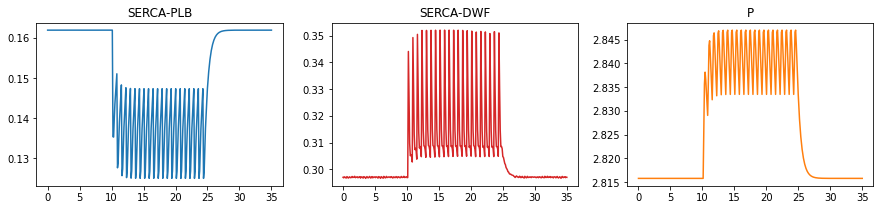

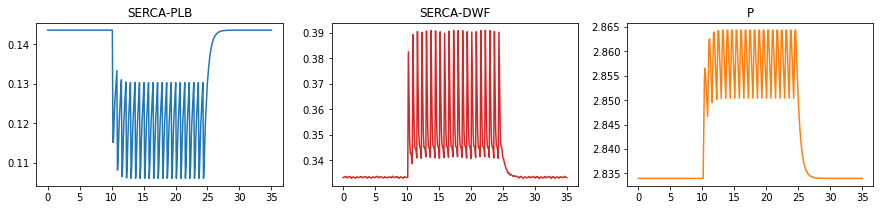

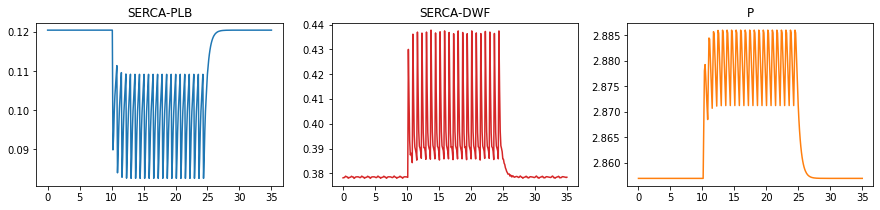

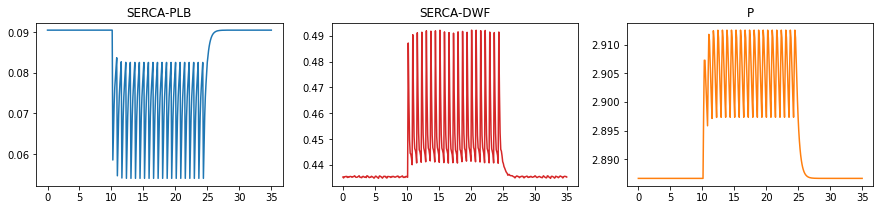

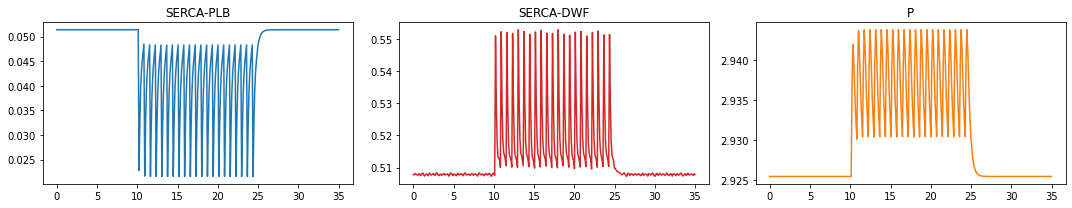

In [ ]:
# 1.5 Hz pacing
# params
# parameters used
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 10,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'noise': False,      # option to add in noise
    'Cadia':0.0,
    'Casys':1.0,
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

pacingParams['freq']=1.5

Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
# states to plot
toPlot=['SERCA-PLB','SERCA-DWF','P']
cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
normalize=False

for Wt in Wts:
    fig=plt.figure()
    hfParams=pacingParams.copy()
    hfParams['Wt']=Wt
    hfParams['Et']=truth['Et']*0.6
    hfParams['Cadia']=0.5
    hf=simulation(hfParams,output_file='hf_1.5Hz_{}_Wt.csv'.format(Wt))
    ts=hf['ts']
    Cas=hf['Ca']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(hf['SERCA-PLB'][150:200])+np.min(hf['SERCA-PLB'][150:200]))/2
    P_eq=(np.max(hf['P'][150:200])+np.min(hf['P'][150:200]))/2
    EB_amp=np.max(hf['SERCA-PLB'][150:200])-np.min(hf['SERCA-PLB'][150:200])
    print('Wt: ', Wt)
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    # plot & compare
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(label)
        #ax.plot(ts,Cas,'k--')
        vals=hf[label]

        if normalize:
            vals-=np.min(vals)
            vals/=np.max(vals)

        ax.plot(ts,vals,color=cols[i],label='{}_{}'.format(label,key))

        #plt.legend(loc=1,fontsize=10)

plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.2723693618303812
PLB pentamer occupancy:  2.707019568268364
SERCA-PLB oscillation amplitude:  0.01015560500205942
Wt:  0.3
SERCA-PLB occupancy:  0.22222365753651072
PLB pentamer occupancy:  2.756776467497672
SERCA-PLB oscillation amplitude:  0.012556542188844333
Wt:  1.2
SERCA-PLB occupancy:  0.13087262107533135
PLB pentamer occupancy:  2.8459893718562324
SERCA-PLB oscillation amplitude:  0.020739127732447085
Wt:  1.5
SERCA-PLB occupancy:  0.11317635897005762
PLB pentamer occupancy:  2.863013190060786
SERCA-PLB oscillation amplitude:  0.02270040528709394
Wt:  2.0
SERCA-PLB occupancy:  0.09149755192565484
PLB pentamer occupancy:  2.8837594758702614
SERCA-PLB oscillation amplitude:  0.024983465546615763
Wt:  3.0
SERCA-PLB occupancy:  0.06499070163254297
PLB pentamer occupancy:  2.909000621193047
SERCA-PLB oscillation amplitude:  0.027083080422284245
Wt:  6.0
SERCA-PLB occupancy:  0.03346277022872154
PLB pentamer occupancy:  2.9393406014707875
SERCA-PLB os

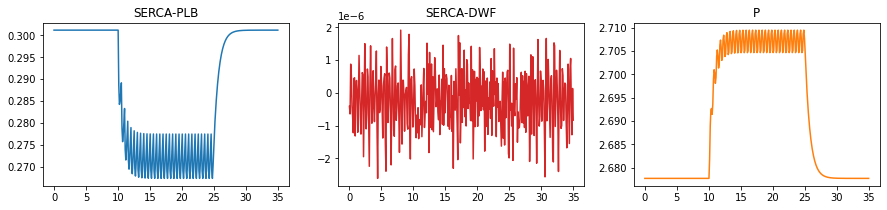

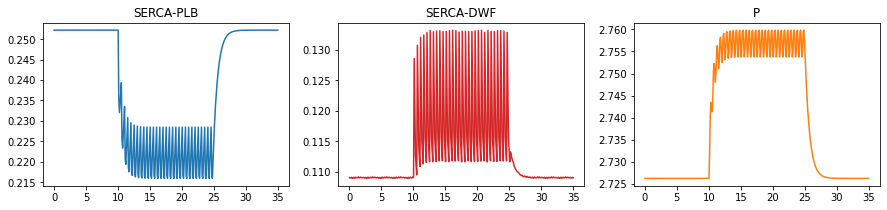

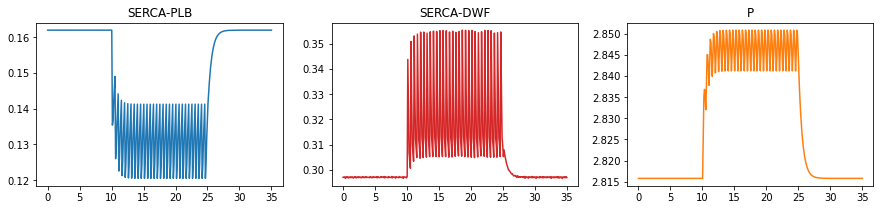

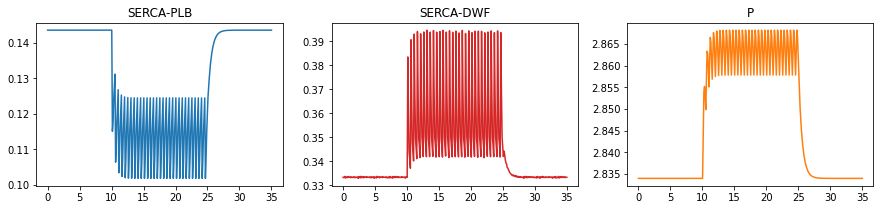

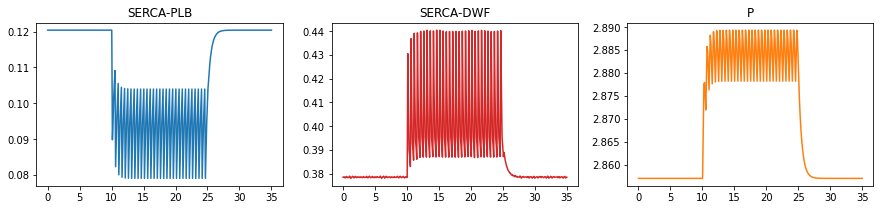

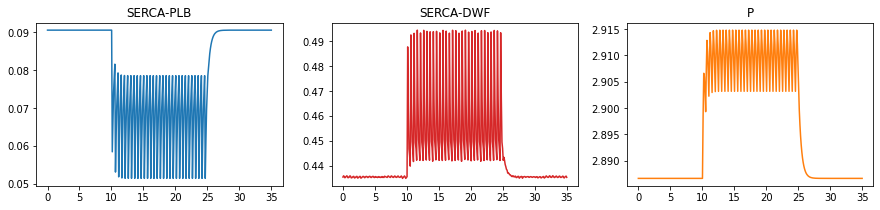

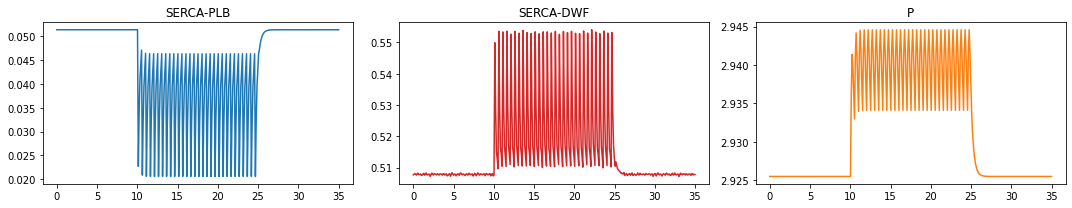

In [18]:
# 2 Hz pacing
# params
# parameters used
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 10,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'noise': False,      # option to add in noise
    'Cadia':0.0,
    'Casys':1.0,
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

pacingParams['freq']=2.0

Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
# states to plot
toPlot=['SERCA-PLB','SERCA-DWF','P']
styles=['-','--','-.',':']
cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
normalize=False

for Wt in Wts:
    fig=plt.figure()
    hfParams=pacingParams.copy()
    hfParams['Wt']=Wt
    hfParams['Et']=truth['Et']*0.6
    hfParams['Cadia']=0.5
    hf=simulation(hfParams,output_file='hf_2Hz_{}_Wt.csv'.format(Wt))
    ts=hf['ts']
    Cas=hf['Ca']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(hf['SERCA-PLB'][150:200])+np.min(hf['SERCA-PLB'][150:200]))/2
    P_eq=(np.max(hf['P'][150:200])+np.min(hf['P'][150:200]))/2
    EB_amp=np.max(hf['SERCA-PLB'][150:200])-np.min(hf['SERCA-PLB'][150:200])
    print('Wt: ', Wt)
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    # plot & compare
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(label)
        #ax.plot(ts,Cas,'k--')
        vals=hf[label]

        if normalize:
            vals-=np.min(vals)
            vals/=np.max(vals)

        ax.plot(ts,vals,color=cols[i],label='{}_{}'.format(label,key))

        #plt.legend(loc=1,fontsize=10)

plt.tight_layout()

Wt:  0.0
SERCA-PLB occupancy:  0.263063525708242
PLB pentamer occupancy:  2.716395243620468
SERCA-PLB oscillation amplitude:  0.006028123455890322
Wt:  0.3
SERCA-PLB occupancy:  0.21261585918090395
PLB pentamer occupancy:  2.766574305025646
SERCA-PLB oscillation amplitude:  0.008683048463909382
Wt:  1.2
SERCA-PLB occupancy:  0.12266706307173059
PLB pentamer occupancy:  2.8550504542400663
SERCA-PLB oscillation amplitude:  0.015958699984920846
Wt:  1.5
SERCA-PLB occupancy:  0.10569347486757108
PLB pentamer occupancy:  2.87156114993888
SERCA-PLB oscillation amplitude:  0.017583239401953554
Wt:  2.0
SERCA-PLB occupancy:  0.08514130771029046
PLB pentamer occupancy:  2.891454950403114
SERCA-PLB oscillation amplitude:  0.019485139159266432
Wt:  3.0
SERCA-PLB occupancy:  0.06044786607131987
PLB pentamer occupancy:  2.915251976283627
SERCA-PLB oscillation amplitude:  0.02125265729278622
Wt:  6.0
SERCA-PLB occupancy:  0.03168798309352865
PLB pentamer occupancy:  2.9431455495794503
SERCA-PLB osci

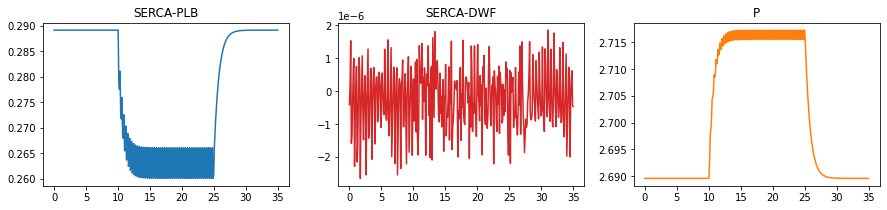

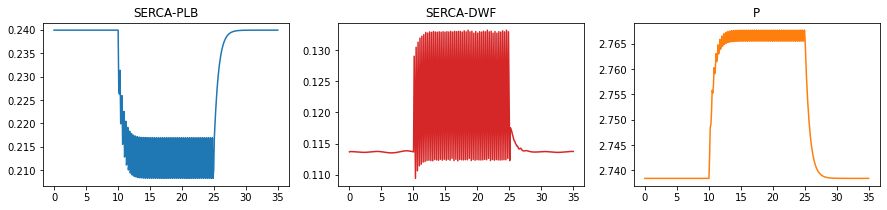

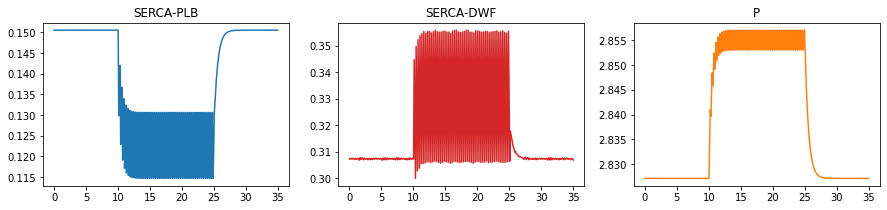

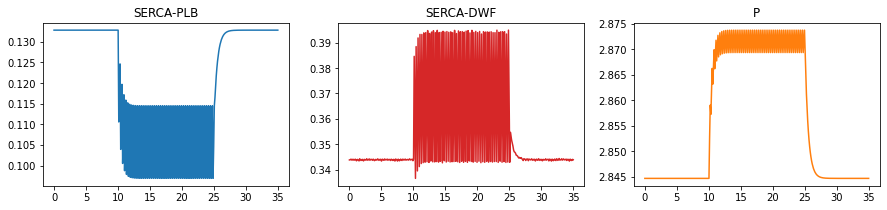

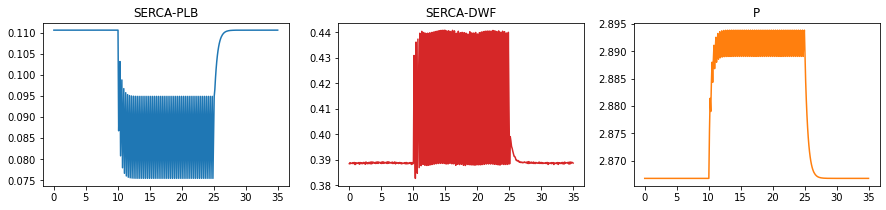

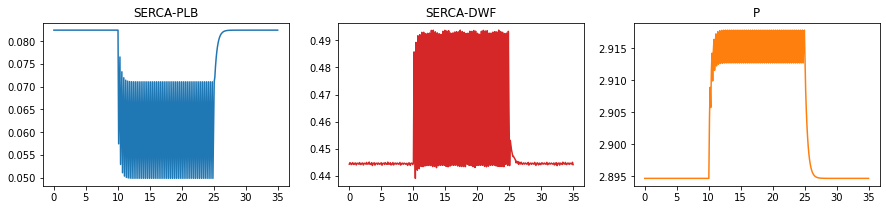

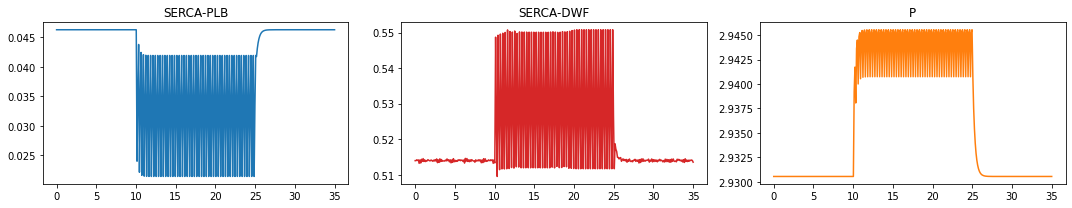

In [19]:
# 3 Hz pacing
# params
# parameters used
pacingParams={   
    'initial':0.0,       
    'setpoint':0.1,      # duration of max Ca
    'n': 3.3,              # define the shape of the Ca transient along with Kd
    'Kd': 0.01,          # define the shape of the Ca transient along with n
    'tBasal': 10,       # duration of initial basal Ca
    'tEnd': 10,         # duration of ending basal Ca
    'freq':1.0,          # pacing freq (Hz)
    'tTrans': 15,     # how long the sim is run
    'noise': False,      # option to add in noise
    'Cadia':0.0,
    'Casys':1.0,
    'y0s': [DPLB_0,SPLB_0,PLBp_0,DW_0,SW_0],
    'k2f': 8110.54,
    'k2b': 111.54,
    'k3f': 5588.13,
    'k3b': 178.87,
    'k4f': 10.00,
    'k4b': 0.079,
    'k5f':35.10,
    'k5b':18.57,
    'k6f':13287.32,
    'k6b': 4802.66,
    'Bt':3.0, 
    'Et':1.0,  
    'Wt':3.0,
}

pacingParams['freq']=3.0

Wts=[0.0, 0.3, 1.2, 1.5, 2.0, 3.0, 6.0]

rcParams['figure.figsize']=15,3
# states to plot
toPlot=['SERCA-PLB','SERCA-DWF','P']
cols=['tab:blue','tab:red','tab:orange','tab:green','tab:purple','gold','tab:cyan','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','lime']
normalize=False

for Wt in Wts:
    fig=plt.figure()
    hfParams=pacingParams.copy()
    hfParams['Wt']=Wt
    hfParams['Et']=truth['Et']*0.6
    hfParams['Cadia']=0.6
    hf=simulation(hfParams,output_file='hf_3Hz_{}_Wt.csv'.format(Wt))
    ts=hf['ts']
    Cas=hf['Ca']
    
    # get stats (SERCA-PLB occupancy, PLB pentamer occupancy, SERCA-PLB oscillation amplitude)
    EB_eq=(np.max(hf['SERCA-PLB'][150:200])+np.min(hf['SERCA-PLB'][150:200]))/2
    P_eq=(np.max(hf['P'][150:200])+np.min(hf['P'][150:200]))/2
    EB_amp=np.max(hf['SERCA-PLB'][150:200])-np.min(hf['SERCA-PLB'][150:200])
    print('Wt: ', Wt)
    print('SERCA-PLB occupancy: ', EB_eq)
    print('PLB pentamer occupancy: ', P_eq)
    print('SERCA-PLB oscillation amplitude: ', EB_amp)
    
    # plot & compare
    for i,label in enumerate(toPlot):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(label)
        #ax.plot(ts,Cas,'k--')
        vals=hf[label]

        if normalize:
            vals-=np.min(vals)
            vals/=np.max(vals)

        ax.plot(ts,vals,color=cols[i],label='{}_{}'.format(label,key))

        #plt.legend(loc=1,fontsize=10)

plt.tight_layout()